Ensure that all of the required packages are installed.

In [1]:
!pip install numpy pandas matplotlib seaborn nltk textblob wordcloud

Import all necessary libraries and packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
import string
from collections import Counter
import warnings
import math
warnings.simplefilter('ignore', category=Warning, lineno=0, append=False)
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('vader_lexicon')

Load the data from our text file.

In [3]:
data = pd.read_csv('../data/amazon_reviews.csv', index_col='Unnamed: 0')
data.head()

,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4915 entries, 0 to 4914
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   reviewerName          4914 non-null   object 
 1   overall               4915 non-null   float64
 2   reviewText            4914 non-null   object 
 3   reviewTime            4915 non-null   object 
 4   day_diff              4915 non-null   int64  
 5   helpful_yes           4915 non-null   int64  
 6   helpful_no            4915 non-null   int64  
 7   total_vote            4915 non-null   int64  
 8   score_pos_neg_diff    4915 non-null   int64  
 9   score_average_rating  4915 non-null   float64
 10  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(5), object(3)
memory usage: 460.8+ KB


In [5]:
print_null = lambda: print("column null values" + "\n" + "="*25 + "\n" + str(data.isnull().sum()))
print_null()

column null values
reviewerName            1
overall                 0
reviewText              1
reviewTime              0
day_diff                0
helpful_yes             0
helpful_no              0
total_vote              0
score_pos_neg_diff      0
score_average_rating    0
wilson_lower_bound      0
dtype: int64


The primary data we want to look at is the `reviewText` if the field is missing, the data is useless, for that reason we will drop the rows with missing data.

In [6]:
data = data.dropna(subset=['reviewText'])

What does the ratings look like, what are the range of score, and is it restricted to integers, or does the user have the flexibilty to make it whatever they want?

In [7]:
data['overall'].value_counts()

overall
5.0    3921
4.0     527
1.0     244
3.0     142
2.0      80
Name: count, dtype: int64

The ratings is scaled from 1 to 5 and are integer values

In [8]:
data.overall = data.overall.astype(int)

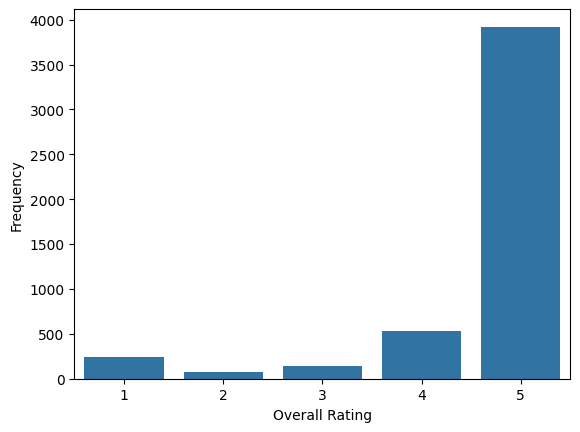

In [9]:
sns.countplot(data=data, x='overall') 
plt.ylabel('Frequency')
plt.xlabel('Overall Rating')
plt.show()

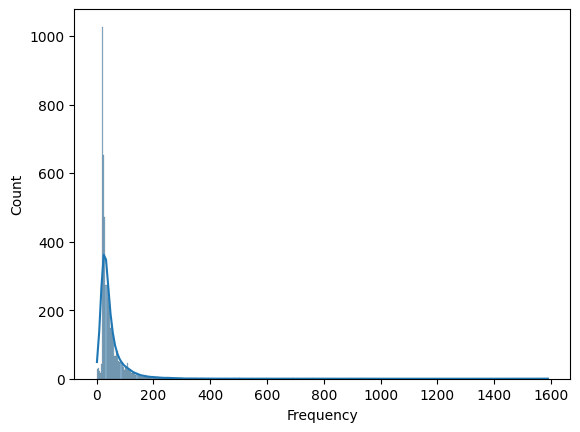

In [10]:
sns.histplot(x=data.reviewText.apply(lambda text: len(text.split(" "))), kde=True)
plt.xlabel('Word Count')
plt.xlabel('Frequency')
plt.show()

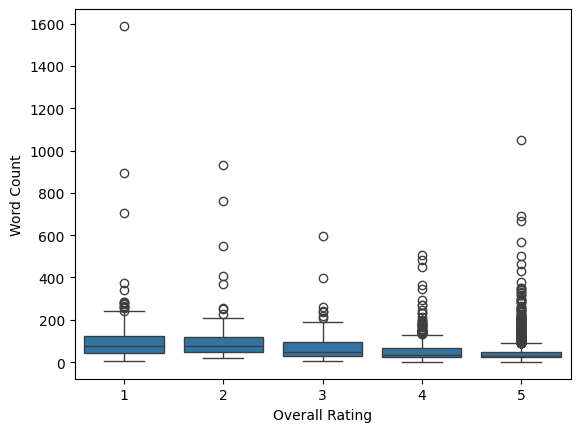

In [11]:
sns.boxplot(x=data.overall, y=data.reviewText.apply(lambda text: len(text.split(" "))))
plt.ylabel('Word Count')
plt.xlabel('Overall Rating')
plt.show()

In [12]:
print_center = lambda text, chars, char: f' {str(text)} '.center(chars, char)
print_padding = lambda text, chars, char: str(' '*chars) + '\n' + str(print_center(text, chars, char)) + '\n' + str(' '*chars)
print_border_bottom = lambda text, chars, char: str(text) + '\n' +  str(char*chars)
print_border_top = lambda text, chars, char: str(text) + '\n' +  str(char*chars)
def print_example():
        chars = 150
        print(print_border_bottom(print_border_bottom(print_center('EXAMPLE TRANSFORMATION', chars, '~'), chars, '|'), chars, ' '))
            
        print(print_border_bottom(print_center('CLEANING TEXT...', chars, '~'), chars, "-"))
        print(print_padding(cleaned_text, chars, ' '))

        print(print_border_bottom(print_center('TOKENIZING...', chars, '~'), chars, "-"))
        print(print_padding(tokenized_sentence, chars, ' '))
        
        print(print_border_bottom(print_center('REMOVING STOPWORDS...', chars, '~'), chars, "-"))
        print(print_padding(removed_stopwords, chars, ' '))
        
        print(print_border_bottom(print_center('LEMAMATIZING WORDS...', chars, '~'), chars, "-"))
        print(print_padding(final_text, chars, ' '))

In [13]:
replace_apostrophe = lambda text: re.sub(r"'", '', text)
replace_punctuation = lambda text: re.sub(rf'[{string.punctuation}]', ' ', text)
remove_excess_spaces = lambda text: re.sub(rf'[{string.punctuation}]', ' ', text).strip()

clean_text = lambda text: remove_excess_spaces(replace_punctuation(replace_apostrophe(text.lower())))

#=================================================================================================================================

tokenize_sentence = lambda sentence: nltk.word_tokenize(sentence)
remove_stopwords = lambda tokenized_sentence: [word for word in tokenized_sentence if word not in set(stopwords.words('english'))]
remove_rare_words = lambda tokenized_sentence, word_counts: [word for word in tokenized_sentence if word not in word_counts[word_counts <= 1]]
lemamatize_words = lambda tokenized_sentence: [WordNetLemmatizer().lemmatize(word) for word in tokenized_sentence]
stem_text = lambda tokenized_sentence: [PorterStemmer().stem(word) for word in tokenized_sentence]

def transform_text(data):
    data = data.apply(clean_text)
    print(data.head(5))
    data = data.apply(tokenize_sentence)
    print(data.head(5))
    data = data.apply(remove_stopwords)
    print(data.head(5))
    word_counts = pd.Series([word for sentence in data for word in sentence]).value_counts()
    data = data.apply(lambda tokenized_sentence: remove_rare_words(tokenized_sentence, word_counts))
    print(data.head(5))
    data = data.apply(lemamatize_words)
    print(data.head(5))
    return data

In [14]:
get_vocabulary = lambda tokenized_sentences: set([word for text in tokenized_sentences for word in text])

In [15]:
data.reviewText = transform_text(data.reviewText)
data.head(5).reviewText

0                                            no issues
1    purchased this for my device  it worked as adv...
2    it works as expected  i should have sprung for...
3    this think has worked out great had a diff  br...
4    bought it with retail packaging  arrived legit...
Name: reviewText, dtype: object
0                                         [no, issues]
1    [purchased, this, for, my, device, it, worked,...
2    [it, works, as, expected, i, should, have, spr...
3    [this, think, has, worked, out, great, had, a,...
4    [bought, it, with, retail, packaging, arrived,...
Name: reviewText, dtype: object
0                                             [issues]
1    [purchased, device, worked, advertised, never,...
2    [works, expected, sprung, higher, capacity, th...
3    [think, worked, great, diff, bran, 64gb, card,...
4    [bought, retail, packaging, arrived, legit, or...
Name: reviewText, dtype: object
0                                             [issues]
1    [purchased, device,

0                                              [issue]
1    [purchased, device, worked, advertised, never,...
2    [work, expected, higher, capacity, think, made...
3    [think, worked, great, 64gb, card, went, south...
4    [bought, retail, packaging, arrived, legit, en...
Name: reviewText, dtype: object

In [16]:
vocabulary = get_vocabulary(data.reviewText)

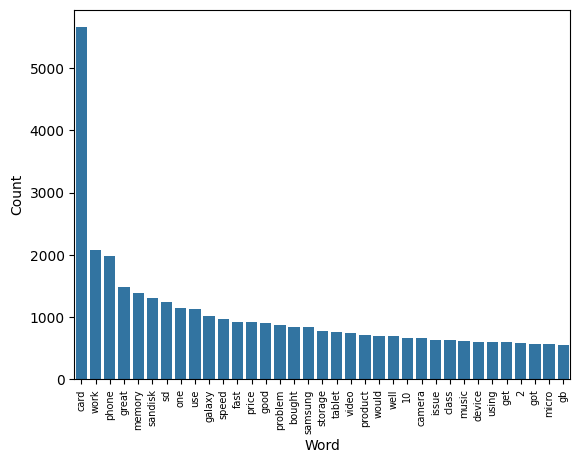

In [17]:
word_counts = pd.Series([word for sentence in data.reviewText for word in sentence]).value_counts().sort_values(ascending=False)
sns.barplot(x=word_counts[:35].keys(), y=word_counts[:35].values)
plt.xticks(rotation=90, fontsize=7)
plt.xlabel("Word")
plt.ylabel("Count")
plt.show()

In [18]:
word_counts[word_counts <= 1]

Series([], Name: count, dtype: int64)

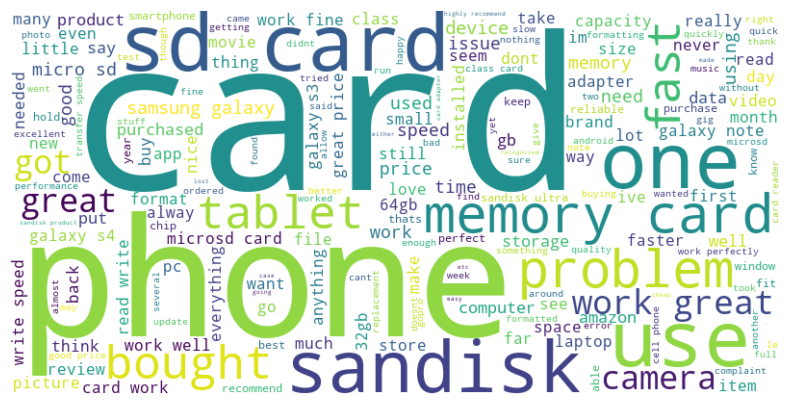

In [19]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join([word for sentence in data.reviewText for word in sentence]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()